In [1]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Data Transformation
trans = transforms.ToTensor()

# Download and load FashionMNIST dataset
mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)

# DataLoader
train_iter = data.DataLoader(mnist_train, batch_size=256, shuffle=True)
test_iter = data.DataLoader(mnist_test, batch_size=256, shuffle=False)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Inputs : 784, Hidden Layer Units: 256, Output: 10
class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self,X):
        return self.network(X)
    
    def predict(self, X):
        # Forward pass and return predicted class
        probs = self.forward(X)
        return torch.argmax(probs, dim=1)

In [13]:
from torchinfo import summary

model = MLP()
summary(model,input_size=(256,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [256, 10]                 --
├─Sequential: 1-1                        [256, 10]                 --
│    └─Flatten: 2-1                      [256, 784]                --
│    └─Linear: 2-2                       [256, 256]                200,960
│    └─ReLU: 2-3                         [256, 256]                --
│    └─Linear: 2-4                       [256, 10]                 2,570
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 52.10
Input size (MB): 0.80
Forward/backward pass size (MB): 0.54
Params size (MB): 0.81
Estimated Total Size (MB): 2.16

In [18]:
model.to(device)

batch_size, lr, epochs = 256, 0.1, 10
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=lr)

In [19]:
# Evaluation
def evaluate_accuracy(model, data_iter):
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for X, y in data_iter:
            X,y = X.to(device), y.to(device)
            y_pred = model.predict(X)
            correct_predictions += (y_pred == y).sum().item()
            total_samples += y.size(0)
    
    return correct_predictions / total_samples

In [20]:
# Train 
def train_loop(train_iter,model,optimizer,loss_func):
    train_total = 0
    train_correct = 0
    for X,y in train_iter:
        X,y = X.to(device), y.to(device)
        
        # forward pass
        y_pred = model.forward(X)
        
        # calculate loss
        loss = loss_func(y_pred,y)
        
        # clear gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()
        
        # update params
        optimizer.step()

        # calculate train acc
        _, predicted = torch.max(y_pred, 1)  # Get the predicted class
        train_total += y.size(0)  # Total number of samples
        train_correct += (predicted == y).sum().item()  # Correct predictions

    # Calculate metrics
    train_loss = torch.Tensor.item(loss.mean())
    train_acc = train_correct / train_total
    
    return train_loss, train_acc

In [21]:
# Train Function
def train_model(train_iter, test_iter,model,optimizer,loss_func,epochs):
    train_loss = []
    train_acc = []
    test_accuracy = []
    for epoch in range(0,epochs):
        train_metrics = train_loop(train_iter,model,optimizer,loss_func)
        test_acc = evaluate_accuracy(model,train_iter)
        train_loss.append(train_metrics[0])
        train_acc.append(train_metrics[1])
        test_accuracy.append(test_acc)
        # print loss in each epoch
        print(f'Epoch: {epoch + 1}, Loss: {train_metrics[0]}, Train Accuracy: {train_metrics[1]}, Test Accuracy: {test_acc}')
    
    return train_loss, train_acc, test_accuracy
        

In [22]:
# Train model
metrics = train_model(train_iter,test_iter, model, optimizer, loss_func, epochs)

Epoch: 1, Loss: 0.8555775284767151, Train Accuracy: 0.6301666666666667, Test Accuracy: 0.7069666666666666
Epoch: 2, Loss: 0.7118013501167297, Train Accuracy: 0.7313, Test Accuracy: 0.74205
Epoch: 3, Loss: 0.5956481695175171, Train Accuracy: 0.77095, Test Accuracy: 0.7777333333333334
Epoch: 4, Loss: 0.5732830166816711, Train Accuracy: 0.7832833333333333, Test Accuracy: 0.7938333333333333
Epoch: 5, Loss: 0.5396181344985962, Train Accuracy: 0.8012333333333334, Test Accuracy: 0.8142333333333334
Epoch: 6, Loss: 0.5246901512145996, Train Accuracy: 0.8128666666666666, Test Accuracy: 0.8236833333333333
Epoch: 7, Loss: 0.5250496864318848, Train Accuracy: 0.8133166666666667, Test Accuracy: 0.8193833333333334
Epoch: 8, Loss: 0.4810226559638977, Train Accuracy: 0.8242166666666667, Test Accuracy: 0.8348833333333333
Epoch: 9, Loss: 0.5048136115074158, Train Accuracy: 0.8278, Test Accuracy: 0.8367
Epoch: 10, Loss: 0.4878482222557068, Train Accuracy: 0.8299333333333333, Test Accuracy: 0.81231666666666

In [25]:
plt.style.use('ggplot')

In [26]:
import seaborn as sns

def plot_graph(metrics):
    sns.lineplot(metrics[0], label = "Train Loss")
    sns.lineplot(metrics[1], label = "Train Accuracy")
    sns.lineplot(metrics[2], label = "Test Accuracy")
    plt.show()

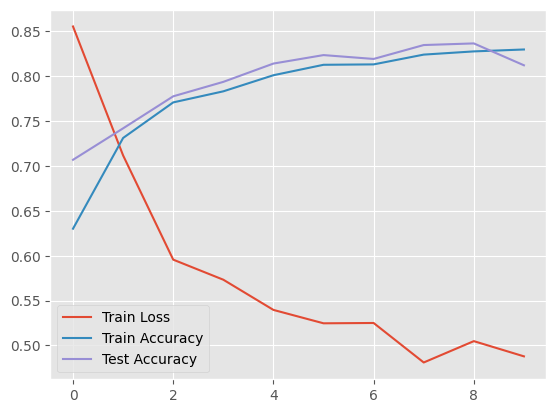

In [27]:
plot_graph(metrics)